In [2]:
import json
from Bio import SeqIO, Phylo, Seq
from string import digits
import pandas as pd
from collections import defaultdict, Counter
import matplotlib.pyplot as plt

In [3]:
def CDS_list(reference):
    """this function finds CDS location and returns a dictionary of the relevant locations"""
    cds_ = []
    for feature in reference.features:
        if feature.type == 'CDS': 
            cds_.extend(list(feature.location))
    return(cds_)

def before_and_after (reference, nr, location, nucl):
        """this function returns counts of nucleotides before or after a specific nucleotide in the CDS region of the reference"""

        ref = SeqIO.read(reference, "genbank")
        CDS_ = CDS_list(ref)
        all_motifs = []
        for i, nu in enumerate(ref.seq):
            if nu == nucl and i in CDS_:    
                if location == "before" and i-nr in CDS_:
                    if "N" not in ref.seq[i-1]:
                        all_motifs.append(ref.seq[i-nr])
                if location == "after" and i+nr in CDS_:
                    if 'N' not in ref.seq[i+1]:
                     all_motifs.append(ref.seq[i+1])
        return(Counter(all_motifs))


def CDS_finder(reference):
    """this function finds CDS location and not CDS location, and saves only those not located at the end of the function"""
    cds_ = dict()
    for feature in reference.features:
        if feature.type == 'CDS': 
            cds_[feature.qualifiers['gene'][0]] = (list(feature.location))
    return(cds_)


ref_file = SeqIO.read("data/areference.gbk", "genbank")


def mutation_recursive(node, dictionary_=None, new_=None):
    """ this function returns a dictionary with node name as key and a list of mutations along that branch as the info, and excludes deletions and unknowns"""
    gene_cds = CDS_finder(ref_file)
    if new_ is None: new_ = []
    if dictionary_ is None: dictionary_ = dict()
    if 'mutations' in node['branch_attrs']:
        aa_mutations, new_, in_it = ([] for i in range(3))
        if 'nuc' in node['branch_attrs']['mutations']:
            for gene, loc in gene_cds.items():
                if gene in node['branch_attrs']['mutations']:
                    for mut in node['branch_attrs']['mutations'][gene]:
                        aa_mutations.append(int(mut[1:-1])*3+loc[0])
            for mut in node['branch_attrs']['mutations']['nuc']:
                if '-' not in mut and '*' not in mut and 'N' not in mut and "R" not in mut and "Y" not in mut and "M" not in mut and "D" not in mut:
                    if int(mut[1:-1]) not in aa_mutations and int(mut[1:-1])+2 not in aa_mutations and int(mut[1:-1])+1 not in aa_mutations:
                        new_.append(mut)
                    else: in_it.append(mut[1:-1])
    if 'name' in node:
            dictionary_[node['name']] = new_
    if 'children' in node:
        for child in node['children']:
           mutation_recursive(child, dictionary_, new_=None)
    return(dictionary_)

ref_file = SeqIO.read("data/areference.gbk", "genbank")
with open ("data/rsv_a_genome.json") as file_:
    f = json.load(file_)  
    mut_by_node = mutation_recursive(f['tree'])

def find_relevant_nucl(sequencefile, dictionarysynonymous, motif, where):
    """this function takes as input reconstructed tree branches and a dictionary of synonymous mutations and returns nucleotides before or after the mutation of interest"""
    records = SeqIO.parse(sequencefile, "fasta")
    output = []
    for record in records:
        for mut in dictionarysynonymous[record.id]:
            if f'{mut[0]}{mut[-1]}' == motif:
                    location_of_mut = int(mut[1:-1])-1
                    if where == "after":
                        nucleotide = record.seq[location_of_mut+1]
                        if nucleotide != '-' and nucleotide!= 'N': output.append(nucleotide)
                    if where == "before":
                        nucleotide = record.seq[location_of_mut-1]
                        if nucleotide != '-' and nucleotide!= 'N': output.append(nucleotide)
    return(Counter(output))

# multiply by nr of branches
sequences = SeqIO.parse("data/reconstructed_sequences.fasta", "fasta")
length = 0
for i in sequences:
    length+=1

In [ ]:
def CDS_list(reference):
    """this function finds CDS location and returns a dictionary of the relevant locations"""
    cds_ = []
    for feature in reference.features:
        if feature.type == 'CDS': 
            cds_.extend(list(feature.location))
    return(cds_)



In [4]:
#dataframe of counts
tree_ = Phylo.read("data/a_tree.nwk", "newick")
treelength = tree_.total_branch_length()


combos = ["CT", "CA", "CG", "TC", "TA", "TG", "AC", "AG", "AT", "GC", "GT", "GA"]
all_dictionaries = dict()
for mut in combos:
    all_= find_relevant_nucl("data/reconstructed_sequences.fasta", mut_by_node, mut, "before")
    print(all_)
    scale = before_and_after("data/areference.gbk", 1, "before", mut[0])
    scaled_ ={x:float(all_[x])/(scale[x]*treelength) for x in all_}
    all_dictionaries[mut]= scaled_

df = pd.DataFrame(all_dictionaries.values()).T
df.columns = ['{}'.format(i) for i in all_dictionaries.keys()]
print("likelihood of mutations before certain nucleotide")
print(df)

Counter({'A': 1355, 'C': 1224, 'T': 995, 'G': 483})
Counter({'T': 221, 'C': 192, 'A': 125, 'G': 46})
Counter({'T': 14, 'C': 5, 'A': 3, 'G': 3})
Counter({'A': 1463, 'C': 1252, 'T': 840, 'G': 573})
Counter({'C': 226, 'T': 187, 'A': 84, 'G': 44})
Counter({'T': 40, 'C': 37, 'A': 21, 'G': 17})
Counter({'C': 108, 'A': 83, 'T': 49, 'G': 9})
Counter({'A': 894, 'T': 677, 'C': 467, 'G': 299})
Counter({'C': 378, 'T': 141, 'A': 75, 'G': 63})
Counter({'G': 4, 'T': 4, 'A': 1, 'C': 1})
Counter({'T': 94, 'A': 36, 'C': 22, 'G': 16})
Counter({'A': 907, 'T': 687, 'C': 416, 'G': 280})
likelihood of mutations before certain nucleotide
         CT        CA        CG        TC        TA        TG        AC  \
T  1.364073  0.302975  0.019193  0.798696  0.177805  0.038033  0.035426   
C  2.559276  0.401455  0.010455  1.775010  0.320409  0.052456  0.082893   
A  1.425137  0.131470  0.003155  0.885836  0.050861  0.012715  0.040429   
G  1.126023  0.107240  0.006994  0.892151  0.068507  0.026469  0.010061   

  

{4: 0.10846472793861706, 16: 0.10846472793861706, 44: 0.10846472793861706, 50: 0.03615490931287235, 26: 0.18077454656436176, 14: 0.03615490931287235, 32: 0.0723098186257447, 37: 0.8315629141960641, 20: 0.0723098186257447, 29: 0.0723098186257447, 13: 0.0723098186257447, 65: 0.10846472793861706, 56: 0.3615490931287235, 68: 0.1446196372514894, 8: 0.0723098186257447, 53: 0.03615490931287235, 25: 0.10846472793861706, 3: 0.03615490931287235, 10: 0.0723098186257447, 43: 0.03615490931287235, 59: 0.03615490931287235, 58: 0.03615490931287235, 47: 0.10846472793861706, 67: 0.10846472793861706, 7: 0.0723098186257447, 5: 0.03615490931287235, 38: 0.03615490931287235, 31: 0.03615490931287235, 34: 0.03615490931287235, 2: 0.03615490931287235, 23: 0.03615490931287235, 11: 0.03615490931287235, 49: 0.03615490931287235, 35: 0.03615490931287235, 46: 0.03615490931287235, 42: 0.03615490931287235, 40: 0.03615490931287235}


Text(0, 0.5, 'amount of mutations')

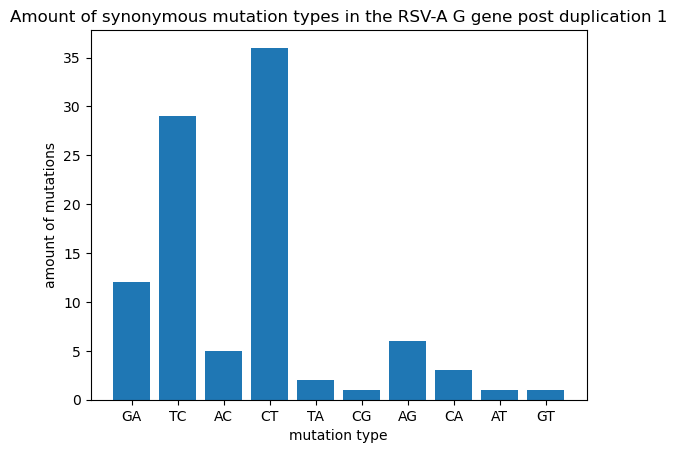

In [77]:
def separate_duplications(lengthofdupl):
    """
    Divides sequences from duplication file into preduplication, and postduplication copies 1 and 2
    By splitting the files into two parts based on duplication length
    
    inputs: length of duplication (72 for RSV-A and 60 for RSV-B)
            duplication file (fasta file containing aligned duplicated regions)
    outputs:
        - preduplication dictionary 
        - postduplication dictionary (first copy)
        -postduplication dictionary (second copy)
    
    """
    duplicationfile = SeqIO.parse("data/last_reconstruction.fasta", "fasta")
    preduplication, postduplication_1, postduplication_2 = (defaultdict(list) for i in range(3))
    for entry in duplicationfile:
        if '-' not in entry.seq:
            copy_1 = entry.seq[:int(lengthofdupl)][1:-2]
            copy_2 = entry.seq[int(lengthofdupl):][1:-2]
            for i in range(0, len(copy_1), 3):
                postduplication_1[entry.id].append(copy_1[i:i+3])
            for i in range(0, len(copy_2), 3):
                postduplication_2[entry.id].append(copy_2[i:i+3])
        else:
            preduplication_ = entry.seq.replace("-", "")
            if len(preduplication_)== int(lengthofdupl):
                preduplication_ = preduplication_[1:-2]
                for i in range(0, len(preduplication_), 3):
                    preduplication[entry.id].append(preduplication_[i:i+3])
    return(postduplication_1, postduplication_2, preduplication)


def recursive_mutations(treefile, copy):
    """
    Makes basic first reconstruction of common mutations moved to common ancestor. 
    Mutations are split into synonymous and nonsynonymous based on if they result in amino acid change or not. 

    inputs:
        - open newick tree file (rooted at midpoint)
        - copy: dictionary of sequences in a copy of the duplication
    outputs:
        - dictionary synonymous: rudimentary first reconstruction of the common mutations in the copy in dictionary form (synonymous)
        - dictionary nonsynonymous: same as above but nonsynonymous
    """
    synonymous_, nonsynonymous_ = (defaultdict(list) for i in range(2))
    for branch in treefile.get_nonterminals(order='postorder'):
        if branch.name in copy:
            for b in branch:
                if b.name in copy:
                    index = 0
                    for codon_branch, codon_b in zip(copy[branch.name], copy[b.name]):
                        if codon_branch != codon_b:
                            if Seq.translate(codon_branch) == Seq.translate(codon_b):
                                pos = 0
                                for char_branch, char_b in zip(codon_branch, codon_b):
                                    pos +=1
                                    if char_branch != char_b:
                                        entry_unsorted = f'{char_b}{char_branch}{pos+(index*3)}'
                                        synonymous_[b.name].append(str("".join(entry_unsorted[:2])+ entry_unsorted[2:]))
                            else:
                                pos = 0
                                for char_branch, char_b in zip(codon_branch, codon_b):
                                    pos +=1
                                    if char_branch != char_b:
                                        entry_unsorted = f'{char_b}{char_branch}{pos+(index*3)}'
                                        nonsynonymous_[b.name].append(str("".join(entry_unsorted[:2])+ entry_unsorted[2:]))
                        index+=1
    return(nonsynonymous_, synonymous_)

def refine_recursive(treefile, synonymous, nonsynonymous):
    """
    Refines the common mutation function described above. 
    Mutations present in multiple branches are moved further up the tree and exceptions due to sequencing errors are taken into account.

    inputs:
        dictionary synonymous (dictionary of branches and synonymous mutations)
        dictionary nonsynonymous (same as above but nonsynonymous)
        read nwk tree file rooted at midpoint, with the relevant branches

    outputs:
        dictionaries for synonymous and nonsynonymous common mutations.
    
    """
    for branch in treefile.get_nonterminals(order='postorder'):
        if branch.name in synonymous:
            for b in branch:
                if b.name in synonymous:
                    synonymous[b.name] = list(set(synonymous[b.name]).difference(set(synonymous[branch.name])))
        if branch.name in nonsynonymous:
            for b in branch:
                if b.name in synonymous:
                    nonsynonymous[b.name] = list(set(nonsynonymous[b.name]).difference(set(nonsynonymous[branch.name])))
    for branch in treefile.get_nonterminals(order='preorder'):
        sort_branch = []
        for e in nonsynonymous[branch.name]:
            sort_branch.append(str("".join(sorted(e[:2]+ e[2:]))))
        for b in branch:
            if b.name in nonsynonymous:
                sort_b = []
                for entry in nonsynonymous[b.name]:
                    sort_b.append(str("".join((entry[:2]+ entry[2:]))))
                nonsynonymous[b.name] = set(set(sort_b).difference(set(sort_branch)))
    return(nonsynonymous, synonymous)


def mutations(synonymous, nonsynonymous):
    """
    Returns locations of synonymous and nonsynonymous mutations in list format
    
    Inputs:
        synonymous mutation dictionary
        nonsynonymous mutation dictionary
    Outputs:
        - list of nonsynonymous mut location
        - list of synonymous mut location
    """
    syn_, nonsyn_, lst_s, lst_n = ([] for i in range(4))
    for i in synonymous.values():
        ls = list(i)
        for j in ls: lst_s.append(j)
    for item_ in lst_s: syn_.append(int(item_[2:]))
    for i in nonsynonymous.values():
        ls = list(i)
        numbers_ = []
        for it in ls:numbers_.append(it[2:])
        new_numbers_ = list(set(numbers_))
        for j in new_numbers_: lst_n.append(j)
    for item_ in lst_n: nonsyn_.append(int(item_))
    
    return(nonsyn_, syn_)

duplication_file = SeqIO.parse("data/last_reconstruction.fasta", 'fasta')
synonymous_one, nonsynonymous_one  = (defaultdict(list) for i in range(2))
tree_file  = Phylo.read("data/duplication/a_dupl_tree.nwk", "newick")
tree_file.root_at_midpoint()
tree_file.find_clades()

total_len = tree_file.total_branch_length()
seq_dict = dict()
for record in duplication_file:
    seq_dict[record.id] = record.seq
for branch in tree_file.get_nonterminals(order='preorder'):
    if pd.isna(branch.name) == False:
        if '-'*int(72) not in seq_dict[branch.name]:
            with_dupl = branch.total_branch_length()
            break
without_dupl = total_len-with_dupl

copy1, copy2, preduplication = separate_duplications(72)
nonsynonymous_1, synonymous_1 = recursive_mutations(tree_file, copy1)
nonsynonymous_2, synonymous_2 = recursive_mutations(tree_file, copy2)
nonsynonymous_pre, synonymous_pre = recursive_mutations(tree_file, preduplication)
nonsynonymous_1_refined, synonymous_1_refined = refine_recursive(tree_file, nonsynonymous_1, synonymous_1)
nonsynonymous_2_refined, synonymous_2_refined = refine_recursive(tree_file, nonsynonymous_2, synonymous_2)
nonsynonymous_pre_refined, synonymous_pre_refined = refine_recursive(tree_file, nonsynonymous_pre, synonymous_pre)
nonsyn_1, syn_1 = mutations(synonymous_1_refined, nonsynonymous_1_refined)
nonsyn_2, syn_2 = mutations(synonymous_2_refined, nonsynonymous_2_refined)
nonsyn_pre, syn_pre = mutations(synonymous_pre_refined, nonsynonymous_pre_refined)

scaled_syn_one, scaled_syn_1, scaled_syn_2, scaled_nonsyn_one, scaled_nonsyn_1, scaled_nonsyn_2 = (dict() for i in range(6))

predupl_ = [syn_pre, nonsyn_pre]
predupl_dicts = [scaled_syn_one, scaled_nonsyn_one]
post_dupl = [syn_1, syn_2, nonsyn_1, nonsyn_2]
post_dupl_dicts = [scaled_syn_1, scaled_syn_2, scaled_nonsyn_1, scaled_nonsyn_2]

for a, b in zip(predupl_, predupl_dicts):
    for key, entry in Counter(a).items():
        b[key] = (entry/without_dupl)/int(72)

for a, b in zip(post_dupl, post_dupl_dicts):
    for key, entry in Counter(a).items():
        b[key] = (entry/with_dupl)/int(72) #normalisation by length of gene and tree with duplication
print(scaled_syn_1)


    #cumulative_syn_1, cumulative_syn_2, cumulative_one_syn = cumulative(scaled_syn_1), cumulative(scaled_syn_2), cumulative(scaled_syn_one)
    #cumulative_nonsyn_1, cumulative_nonsyn_2, cumulative_one_nonsyn = cumulative(scaled_nonsyn_1), cumulative(scaled_nonsyn_2), cumulative(scaled_nonsyn_one)

syn_1_muts = []
for node, muts in synonymous_1_refined.items():
    for m in muts:
        if len(m) == 4:
            syn_1_muts.append(f'{m[:-2]}')
        else:
            syn_1_muts.append(f'{m[:-1]}')
for_graph = Counter(syn_1_muts)
plt.bar(for_graph.keys(), for_graph.values())
plt.title("Amount of synonymous mutation types in the RSV-A G gene post duplication 1")
plt.xlabel("mutation type")
plt.ylabel("amount of mutations")

# dinucleotides



